<a href="https://colab.research.google.com/github/Taiq-UE/StrokeMLPrediction/blob/main/Stroke.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importy

import gdown
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import precision_score, f1_score, matthews_corrcoef, accuracy_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
plt.style.use('dark_background')
sns.set_palette("Set2")

In [2]:
# Wczytanie danych

file_id = '14r2dYYEb1BZHGAfO6zWkt-88g7fvfeE7'
url = f'https://drive.google.com/uc?id={file_id}'
output = 'data.csv'
gdown.download(url, output, quiet=False)
df = pd.read_csv(output)
# df=pd.read_csv("healthcare-dataset-stroke-data.csv")
df.head()

Downloading...
From: https://drive.google.com/uc?id=14r2dYYEb1BZHGAfO6zWkt-88g7fvfeE7
To: /content/data.csv
100%|██████████| 317k/317k [00:00<00:00, 53.9MB/s]


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
# EDA
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

<Axes: xlabel='gender', ylabel='bmi'>

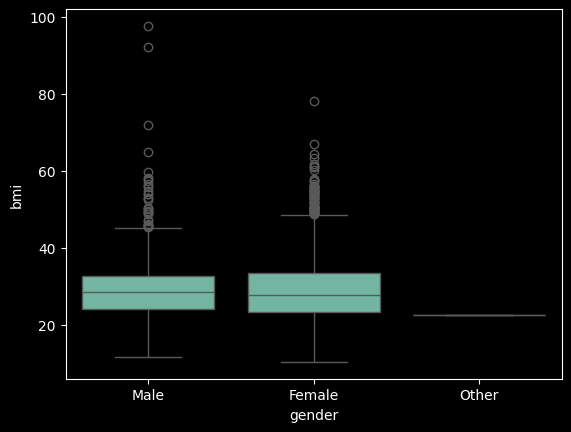

In [4]:
sns.boxplot(x=df['gender'],y=df['bmi'])

<Axes: xlabel='bmi', ylabel='age'>

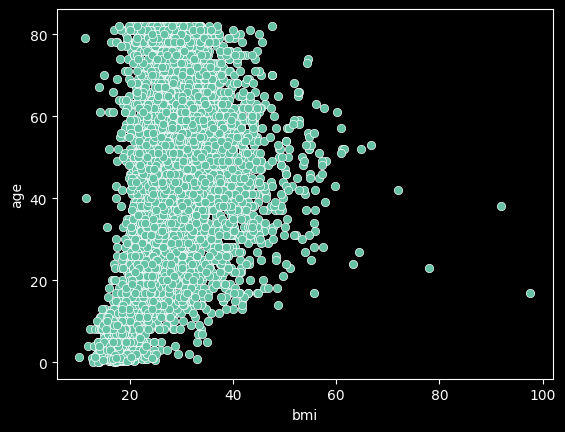

In [5]:
sns.scatterplot(data=df,x='bmi',y='age')

In [6]:
age_group=[]
for i in df['age']:
    if i<2.0:
        age_group.append('Toddler')
    elif i>2.0 and i<=19.0:
        age_group.append('Teen')
    elif i>19.0 and i<60.0:
        age_group.append('Adult')
    else:
        age_group.append('Senior')
df['age_group']=age_group
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_group
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,Senior
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1,Senior
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,Senior
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,Adult
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,Senior


In [7]:
fig = px.box(df, x="age_group", y="bmi",color="gender")
fig.show()

In [8]:
def bmi(cols):
    bmi = cols[0]
    age_group = cols[1]
    gender = cols[2]
    if pd.isnull(bmi):
        if age_group == 'Senior':
            if gender == 'Male':
                return 29.0
            else:
                return 28.9
        elif age_group == 'Adult':
            if gender == 'Male':
                return 30.2
            else:
                return 28.8
        elif age_group == 'Teen':
            if gender == 'Male':
                return 20.6
            else:
                return 21.8
        else:
            if gender == 'Male':
                return 18.9
            else:
                return 18.05
    else:
        return bmi
df['bmi']=df[['bmi','age_group','gender']].apply(bmi,axis=1)
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_group
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,Senior
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.9,never smoked,1,Senior
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,Senior
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,Adult
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,Senior


In [9]:
df.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
age_group            0
dtype: int64

In [10]:
df.duplicated().sum()

0

In [11]:
cat_cols = [col for col in df.columns if col not in ['id', 'stroke', 'age', 'avg_glucose_level', 'bmi', 'hypertension', 'heart_disease']]

In [12]:
cat_cols.append('age_group')
for i in cat_cols:
    print(f'============Values in {i}============\n{df[i].value_counts()}\n------------------------')

============Values in gender============
gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64
------------------------
============Values in ever_married============
ever_married
Yes    3353
No     1757
Name: count, dtype: int64
------------------------
============Values in work_type============
work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64
------------------------
============Values in Residence_type============
Residence_type
Urban    2596
Rural    2514
Name: count, dtype: int64
------------------------
============Values in smoking_status============
smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64
------------------------
============Values in age_group============
age_group
Adult      2768
Senior     1431
Teen        791
Toddler     120
Name: count, dtype: int64
--------

In [13]:
df.drop(index = df[df['gender']=='Other'].index[0] ,axis=0,inplace=True)

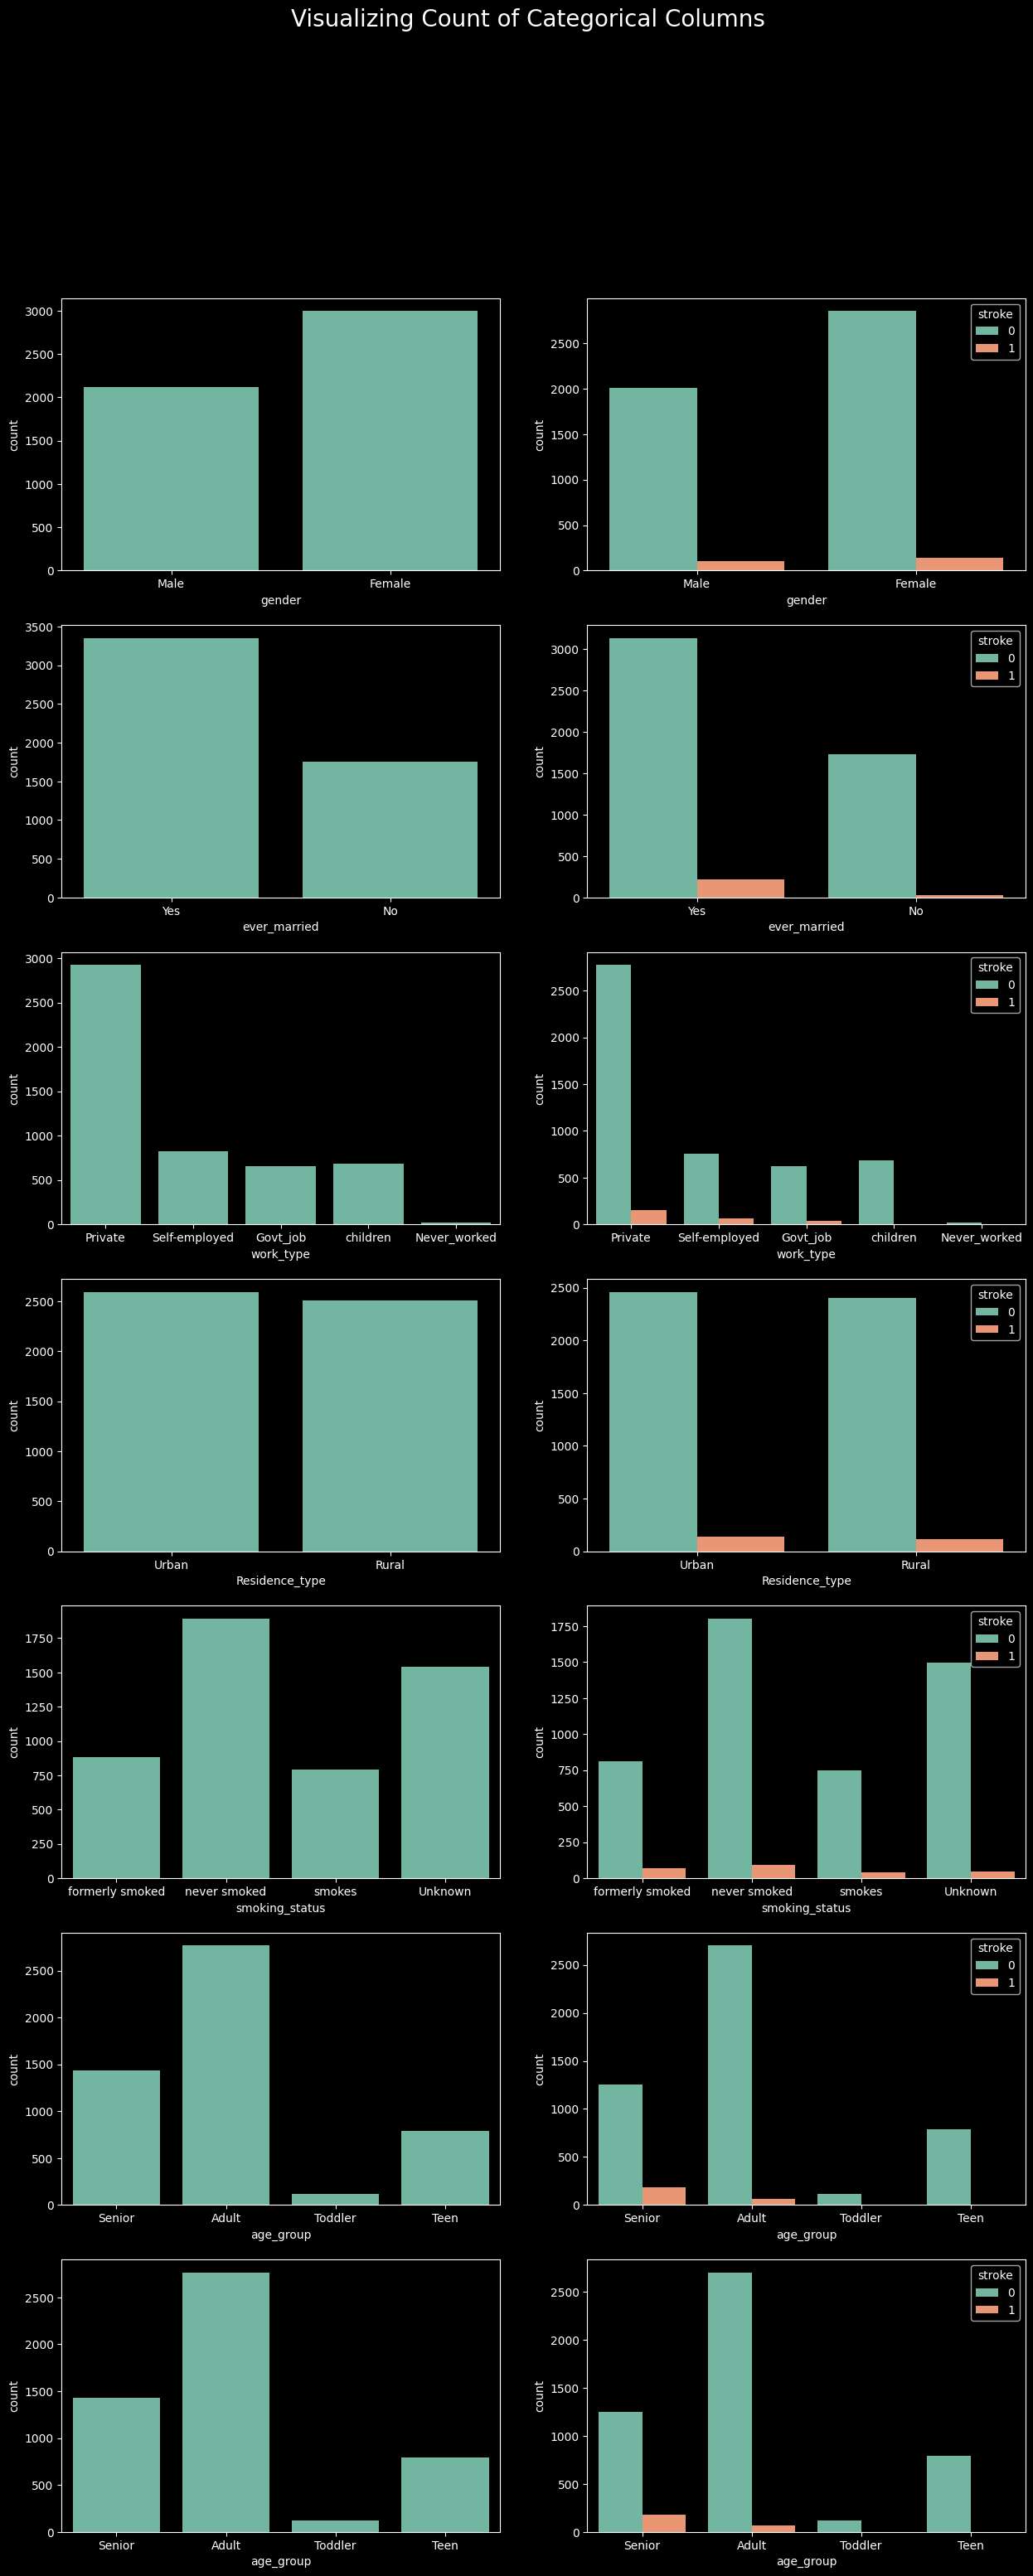

In [14]:
n = len(cat_cols)
fig, ax = plt.subplots(n, 2, figsize=(15, 35))
for index, i in enumerate(cat_cols):
    plt.suptitle("Visualizing Count of Categorical Columns", size=20)
    sns.countplot(data=df, x=i, ax=ax[index, 0])
    sns.countplot(data=df, x=i, ax=ax[index, 1], hue='stroke')

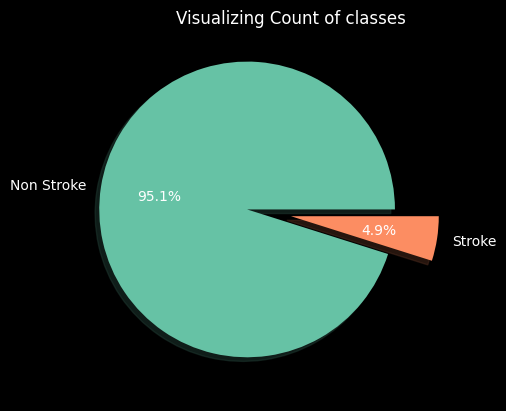

In [15]:
plt.title("Visualizing Count of classes")
plt.pie(np.array(df['stroke'].value_counts()),labels=['Non Stroke','Stroke'],explode=[0.3,0],autopct='%1.1f%%',shadow=True)
plt.show()

In [16]:
df_enc = pd.get_dummies(df[cat_cols], drop_first=True)
df = pd.concat([df, df_enc], axis=1)

In [ ]:
df.drop([col for col in cat_cols if col not in ['hypertension', 'heart_disease']], axis=1, inplace=True)
df.head()

In [ ]:
df_final = df.drop(['id', 'age_group_Senior', 'age_group_Teen', 'age_group_Toddler'], axis=1)
df_final.head()

In [19]:
# Definicja klasyfikatorów
classifiers = [
    RandomizedSearchCV(
        RandomForestClassifier(random_state=42),
        {'n_estimators': [50, 75, 100, 150, 200, 300]},
        cv=5
    ),
    RandomizedSearchCV(
        LogisticRegression(solver='lbfgs'),
        {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'max_iter': [50, 75, 100, 200, 300, 400, 500, 700]},
        cv=5
    ),
    RandomizedSearchCV(
        SVC(),
        {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
        cv=5
    )
]

In [20]:
def model(X, Y, folds):
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=0)
    result_df = pd.DataFrame()

    for clf in classifiers:
        accuracy = []
        recall = []
        precision = []
        f1 = []
        mcc = []
        fold_no = []
        for fold, (train_idx, test_idx) in enumerate(skf.split(X, Y)):
            train_X, val_X = X.iloc[train_idx], X.iloc[test_idx]
            train_y, val_y = Y.iloc[train_idx], Y.iloc[test_idx]

            # Standaryzacja danych
            scaler = StandardScaler()
            con_cols = ['age', 'avg_glucose_level', 'bmi']
            train_X.loc[:, con_cols] = scaler.fit_transform(train_X[con_cols])
            val_X.loc[:, con_cols] = scaler.transform(val_X[con_cols])

            clf.fit(train_X, train_y)
            pred = clf.predict(val_X)

            accuracy.append(round(accuracy_score(val_y, pred), 4))
            recall.append(round(recall_score(val_y, pred), 4))
            precision.append(round(precision_score(val_y, pred), 4))
            f1.append(round(f1_score(val_y, pred), 4))
            mcc.append(round(matthews_corrcoef(val_y, pred), 4))
            fold_no.append(fold + 1)

        temp_df = pd.DataFrame({
            'Accuracy': accuracy,
            'Recall': recall,
            'Precision': precision,
            'F1': f1,
            'MCC': mcc
        }, index=fold_no)

        if isinstance(clf, RandomizedSearchCV):
            temp_df['Classifier'] = clf.estimator.__class__.__name__
        else:
            temp_df['Classifier'] = clf.__class__.__name__
        result_df = pd.concat([result_df, temp_df])

    return result_df

In [21]:
con_cols = ['age', 'avg_glucose_level', 'bmi']

feature_cols = df_final.columns.tolist()
feature_cols = [col for col in feature_cols if col != 'stroke']

oversample = RandomOverSampler(sampling_strategy='minority')
X = df_final[feature_cols]
y = df_final['stroke']
X_over, y_over = oversample.fit_resample(X, y)

# Dzielenie na zestaw treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.3, stratify=y_over, random_state=42)

# Standaryzacja
scaler = StandardScaler()
X_train[con_cols] = scaler.fit_transform(X_train[con_cols])
X_test[con_cols] = scaler.transform(X_test[con_cols])

In [ ]:
# Wywołanie funkcji model
result_df = model(X_train, y_train, 5)

print(result_df)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning:

The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning:

The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning:

The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning:

The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning:

The total space of parameters 

In [ ]:
# Oblicz średnią dokładność dla każdego klasyfikatora
average_accuracy = result_df.groupby('Classifier')['Accuracy'].mean()

sorted_classifiers = average_accuracy.sort_values(ascending=False)

print(sorted_classifiers)

In [ ]:
best_model_name = result_df.groupby('Classifier')['Accuracy'].mean().idxmax()

# Znajdź najlepszy model wśród wcześniej zdefiniowanych klasyfikatorów
best_model = None
for clf in classifiers:
    if clf.estimator.__class__.__name__ == best_model_name:
        best_model = clf
        break

# Przykładowe dane:
new_data = pd.DataFrame({
    'age': [21],
    'hypertension': [0],
    'heart_disease': [0],
    'avg_glucose_level': [90],
    'bmi': [24.4],
    'gender_Male': [1],
    'ever_married_Yes': [0],
    'work_type_Never_worked': [0],
    'work_type_Private': [1],
    'work_type_Self-employed': [0],
    'work_type_children': [0],
    'Residence_type_Urban': [1],
    'smoking_status_formerly smoked': [0],
    'smoking_status_never smoked': [1],
    'smoking_status_smokes': [0]
})

new_data[con_cols] = scaler.transform(new_data[con_cols])

prediction = best_model.predict(new_data)

print(f'Przewidywanie dla nowych danych: {prediction}')